## Decision making in low-rank recurrent neural networks

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import torch
import torch.nn as nn
import random
from scipy import integrate
from scipy.optimize import minimize
from sklearn.metrics import accuracy_score
plt.style.use('dark_background')

## Perceptual decision making

### Exercise 1

__Create a function for generating the data.__

In [2]:
# Defining constants given in the exercise description.
mu = 0
std = 0.03
stim_strengths = lambda data_size: [3.2 / 100 * random.choice(np.array([1, 2, 4, 8, 16])) for i in range(data_size)]

In [3]:
def get_input(u_bar, t_step, mu, std):
    u = np.zeros(t_step)
    for t in range(t_step):
        if 5 <= t <= 45:
            u[t] = u_bar + np.random.normal(mu, std)
        else:
            u[t] = np.random.normal(mu, std)
    
    return u

def generate_data(stim_strengths, t_step, mu, std):
    U = np.zeros((len(stim_strengths), t_step))
    y = np.zeros(len(stim_strengths))
    for trial, stim_strength in enumerate(range(len(stim_strengths))):
        u_bar = np.random.uniform(-stim_strengths[trial], stim_strengths[trial])
        U[trial] = get_input(u_bar, t_step, mu, std)
        y[trial] = np.sign(u_bar)
        
    return torch.from_numpy(U), torch.from_numpy(y)

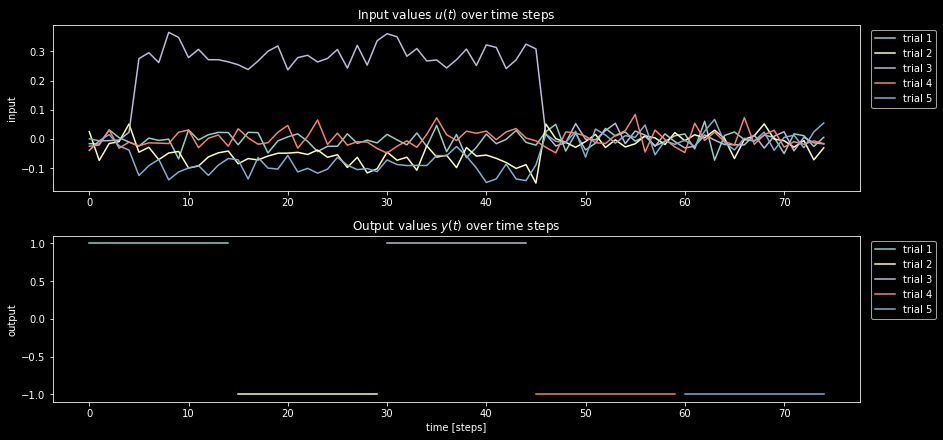

In [4]:
t_steps = 75
U, y = generate_data(stim_strengths(5), t_steps, mu, std)

fig, axs = plt.subplots(2, 1, figsize = (13, 6), constrained_layout = True)
for trial in range(U.shape[0]):
    axs[0].set_title(r'Input values $u(t)$ over time steps')
    axs[0].plot(np.arange(0, t_steps, 1), U[trial], label = f'trial {trial+1}')
    axs[0].set_ylabel('input')
    
    axs[1].set_title(r'Output values $y(t)$ over time steps')
    axs[1].plot(np.arange(trial * t_steps/U.shape[0], (trial+1) * t_steps/U.shape[0], 1), 
                np.full(int(t_steps/U.shape[0]), y[trial]), label = f'trial {trial+1}')
    axs[1].set_ylabel('output')
    axs[1].set_xlabel('time [steps]')

for i in range(2):
    axs[i].legend(loc = 'upper right', bbox_to_anchor = (1.1, 1))
plt.show()

### Exercise 2

__Implement the recurrent neural network in your favorite deep learning library.__

In [5]:
# Define the functions.
phi = lambda x: torch.tanh(x)
dynamics = lambda u, x, t, I, J, tau=0.1: (-x + torch.matmul(J, phi(x)) + I*u[:,t]) / tau
output = lambda x, N: 1 / N * w(N)@phi(x)

In [6]:
def forward_euler(u, x, t, I, J, dt=0.02, tau=0.1):
    x = x + dt * dynamics(u, x, t, I, J, tau)
    return x

In [7]:
class RNNLayer(nn.Module):
    '''
    Single custom RNN layer with a low-rank connectivity matrix and a leak term.
    '''
    def __init__(self, input_size, hidden_size, rank):
        super(RNNLayer, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.m_list = nn.ParameterList([nn.Parameter(torch.normal(torch.zeros(hidden_size), torch.ones(hidden_size)).reshape(hidden_size, input_size)) for i in range(rank)])
        self.n_list = nn.ParameterList([nn.Parameter(torch.normal(torch.zeros(hidden_size), torch.ones(hidden_size)).reshape(hidden_size, input_size)) for i in range(rank)])

    def forward(self, u, I, t, x):
        m_n = torch.zeros((128, 128))
        for i in range(len(self.m_list)):
            m_n += torch.matmul(self.m_list[i], self.n_list[i].T)
            
        J = 1 / self.hidden_size * m_n
        x = forward_euler(u, x, t, I, J)
        return x

In [8]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, rank=1):
        super(Model, self).__init__()
        
        # Define the number of layers and the nodes in each layer.
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.rank = rank
        
        # Define and initialize the fixed weights I and w.
        self.I = torch.normal(torch.zeros(hidden_size), torch.ones(hidden_size)).reshape(hidden_size, input_size)
        self.w = torch.normal(torch.zeros(hidden_size, 1), torch.full((hidden_size, 1), 4)).reshape(hidden_size, input_size)
        
        # Define the network layers.
        self.rnn = RNNLayer(input_size, hidden_size, rank)
        
    def forward(self, u, t, x):
        x = self.rnn(u, self.I, t, x).float()
        z = 1 / self.hidden_size * torch.matmul(self.w.T, phi(x))
        
        return x, z

### Exercise 3

__Train a network of size $N = 128$ by minimizing the mean squared error using stochastic gradient descent.__

In [9]:
def train_network(model, U, y, input_size, hidden_size, t_steps, batch_size=32, n_epochs=100, lr=5e-3, n_last_steps=15):
    time_steps = U.shape[1]
    n_batches = int(U.shape[0] / batch_size)
    last_steps = t_steps - n_last_steps
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    mse_loss = nn.MSELoss()
        
    # x = torch.normal(torch.zeros(hidden_size, batch_size), torch.ones(hidden_size, batch_size))
        
    loss_log = np.zeros(n_epochs)
    x_log = np.zeros((n_epochs, n_batches, hidden_size, batch_size))
    z_log = np.zeros((n_epochs, n_batches, n_last_steps, batch_size))
        
    for epoch in range(1, n_epochs+1):
        epoch_loss = 0
        for batch in range(n_batches):
            # x = torch.zeros(hidden_size, input_size)
            x = torch.zeros(hidden_size, batch_size)
            for t in range(t_steps):
                x, z = model(U[batch*batch_size:(batch+1)*batch_size], t, x)
                
                # Minimize the loss function over the last 15 time steps.
                if t >= last_steps:
                    loss = mse_loss(z.reshape(batch_size).float(), y[batch*batch_size:(batch+1)*batch_size].float())
                    loss.backward()    # Compute the gradients
                    optimizer.step()   # Parameter updates
                                        
                    model.zero_grad()  # Clear the gradients
                    x = x.detach()  
                    
                    epoch_loss += loss
                    x_log[epoch-1, batch] = x.numpy()
                    z_log[epoch-1, batch, (last_steps-t)] = z.detach().numpy()
                    
        loss_log[epoch-1] = epoch_loss / (n_last_steps * n_batches)
        if epoch%10 == 0:
            print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
            print("Loss: {:.4f}".format(loss_log[epoch-1]))
            
    return loss_log, x_log, z_log
# https://stackoverflow.com/questions/48274929/pytorch-runtimeerror-trying-to-backward-through-the-graph-a-second-time-but

In [10]:
# Generate the data.
N = 128
t_steps = 75
batch_size = 32
n_batches = 1
data_size = batch_size * n_batches

stim_strengths_rnn = stim_strengths(data_size)
U, y = generate_data(stim_strengths_rnn, t_steps, mu, std)

In [11]:
# Define the model.
input_size = 1
hidden_size = N
rank = 1
model = Model(input_size, hidden_size, rank)
model

Model(
  (rnn): RNNLayer(
    (m_list): ParameterList(  (0): Parameter containing: [torch.FloatTensor of size 128x1])
    (n_list): ParameterList(  (0): Parameter containing: [torch.FloatTensor of size 128x1])
  )
)

In [12]:
n_epochs = 200
loss, x_log, z_log = train_network(model, U, y, input_size, hidden_size, t_steps, n_epochs=n_epochs)

Epoch: 10/200............. Loss: 0.9957
Epoch: 20/200............. Loss: 0.0374
Epoch: 30/200............. Loss: 0.0056
Epoch: 40/200............. Loss: 0.0015
Epoch: 50/200............. Loss: 0.0006
Epoch: 60/200............. Loss: 0.0004
Epoch: 70/200............. Loss: 0.0002
Epoch: 80/200............. Loss: 0.0002
Epoch: 90/200............. Loss: 0.0001
Epoch: 100/200............. Loss: 0.0001
Epoch: 110/200............. Loss: 0.0001
Epoch: 120/200............. Loss: 0.0001
Epoch: 130/200............. Loss: 0.0001
Epoch: 140/200............. Loss: 0.0000
Epoch: 150/200............. Loss: 0.0000
Epoch: 160/200............. Loss: 0.0000
Epoch: 170/200............. Loss: 0.0000
Epoch: 180/200............. Loss: 0.0000
Epoch: 190/200............. Loss: 0.0000
Epoch: 200/200............. Loss: 0.0000


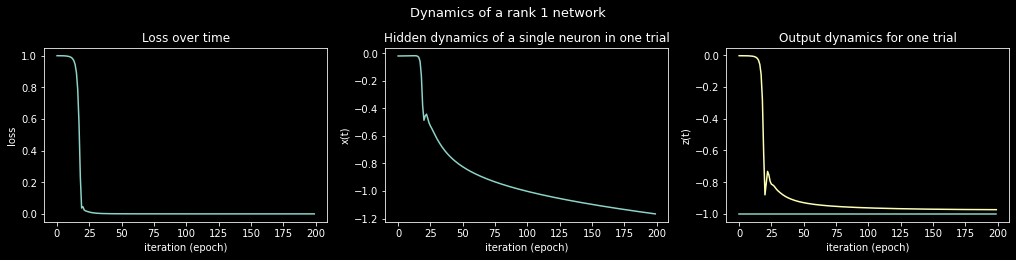

In [13]:
# Plot the loss, hidden and output dynamics.
plots = [loss.flatten(), x_log[:,0,0,0], np.full(n_epochs, y[0]), z_log[:,0,0,0]]
titles = ['Loss over time', 'Hidden dynamics of a single neuron in one trial', 'Output dynamics for one trial']
y_labels = ['loss', 'x(t)', 'z(t)']
fig, axs = plt.subplots(1, 3, figsize = (14, 3.5), constrained_layout = True)
fig.suptitle(f'Dynamics of a rank {rank} network', fontsize = 13)
for i in range(3):
    axs[i].plot(plots[i])
    axs[i].set_title(titles[i])
    axs[i].set_xlabel('iteration (epoch)')
    axs[i].set_ylabel(y_labels[i])
    if i == 2:
        axs[i].plot(plots[3])
        plt.show()

### Exercise 4

__Dubreuil et al. found that their network relied on a specific pattern of correlations between the connectivity vectors (their figure 2b). Explain why this pattern works for the task, and compare it with the pattern in your network.__

Within this framework, each neuron is characterized by its set of _loadings_ corresponding to its input $\mathbf{I}$, readout $\mathbf{w}$ and connectivity patterns $\mathbf{m}$ and $\mathbf{n}$ values. This means that each neuron corresponds to a single point in _loading space_ spanned by the corresponding patterns. Debreuil et al. considered the situation in which _P_ populations of neurons correspond to _P_ Gaussian clusters in the loading space. 

A two-dimensional projection of the connectivity patterns $\mathbf{m}$ and $\mathbf{n}$ in the loading space shows a single Gaussian cluster fully characterized by the corresponding correlation matrix. Their work actually revealed that a single, global Gaussian population was sufficient to implement the perceptual decision making task. From this correlation matrix (covariance matrix without variances) they extracted new networks that performed as good as the original trained network. This works because multivariate Gaussian mixture models (GMMs) are used which can approximate arbitrary joint distributions of loadings.

As depicted in the plot below the covariance matrix, the pattern of our network show the same results in the sense that the 2D projections of the loading space show that we seem to have a single Gaussian cluster as well.

In [14]:
def plt_cov(cov, title, labels):
    fig, ax = plt.subplots()
    fig.canvas.draw()
    
    ax.set_xticks(np.arange(0, len(labels), 1))
    ax.set_yticks(np.arange(0, len(labels), 1))
    ax.set_xticklabels(labels) 
    ax.set_yticklabels(labels) 
    
    im = ax.imshow(cov)
    fig.colorbar(im)
    ax.set_title(title)
    plt.show()

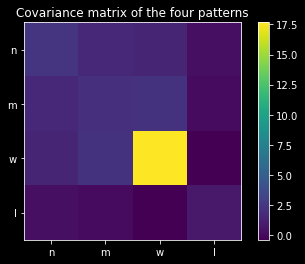

In [15]:
# Statistics of the pattern loadings for a unit rank network after training.
m = model.rnn.m_list[0].detach().numpy().reshape(hidden_size)
n = model.rnn.n_list[0].detach().numpy().reshape(hidden_size)
I = model.I.detach().numpy().reshape(hidden_size)
w = model.w.detach().numpy().reshape(hidden_size)

labels = ['n', 'm', 'w', 'I']
cov = np.cov(np.array([n, m, w, I]))
plt_cov(cov, 'Covariance matrix of the four patterns', labels)

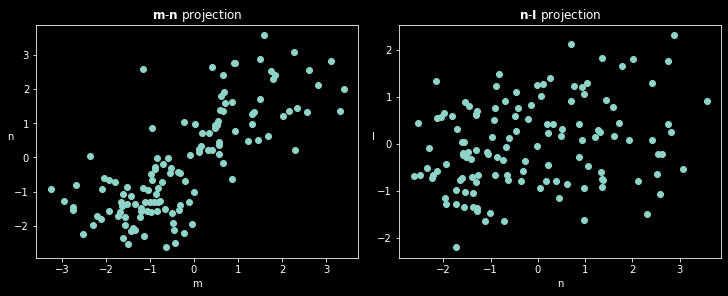

In [16]:
fig, axs = plt.subplots(1, 2, figsize = (10, 4), constrained_layout = True)

axs[0].set_title(r'$\mathbf{m}$-$\mathbf{n}$ projection')
axs[0].scatter(m, n)
axs[0].set_xlabel('m')
axs[0].set_ylabel('n', rotation = 'horizontal')

axs[1].set_title(r'$\mathbf{n}$-$\mathbf{I}$ projection')
axs[1].scatter(n, I)
axs[1].set_xlabel('n')
axs[1].set_ylabel('I', rotation = 'horizontal')
plt.show()

### Exercise 5

__The theory of low-rank networks relies on Gaussian approximations, which characterizes connectivity vectors by their second order statistics. Test if this assumption holds in your trained network by__
- (1) fitting a 4-dimensional Gaussian distribution to the connectivity vectors, 
- (2) Resampling from the fitted distribution, 
- (3) Comparing the empirical with the resampled distribution, and 
- (4) Testing networks with the resampled connectivity by comparing the sign of the output with the sign of the target.

In [17]:
mu_m = np.mean(m)
mu_n = np.mean(n)
mu_I = np.mean(I)
mu_w = np.mean(w)

mu = np.array([mu_m, mu_n, mu_I, mu_w])

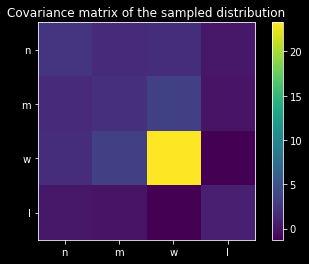

In [18]:
# Fitting and resampling.
sampled_distribution = np.random.multivariate_normal(mu, cov, size = hidden_size)

# Comparing covariance matrices.
cov_sampled = np.cov(sampled_distribution.T)
plt_cov(cov_sampled, 'Covariance matrix of the sampled distribution', labels)

In [19]:
# Test the model with the resampled connectivity.
m_sampled = sampled_distribution[:,0]
n_sampled = sampled_distribution[:,1]
I_sampled = sampled_distribution[:,2]
w_sampled = sampled_distribution[:,3]

# Replacing connectivity patterns in the resampled network with the resampled patterns.
model_sampled = Model(input_size, hidden_size, rank)
model_sampled.rnn.m_list = nn.ParameterList([nn.Parameter(torch.from_numpy(m_sampled.reshape(hidden_size, input_size)).float())])
model_sampled.rnn.n_list = nn.ParameterList([nn.Parameter(torch.from_numpy(n_sampled.reshape(hidden_size, input_size)).float())])
model_sampled.I = torch.from_numpy(I_sampled.reshape(hidden_size, input_size)).float()
model_sampled.w = torch.from_numpy(w_sampled.reshape(hidden_size, input_size)).float()

In [20]:
model_sampled

Model(
  (rnn): RNNLayer(
    (m_list): ParameterList(  (0): Parameter containing: [torch.FloatTensor of size 128x1])
    (n_list): ParameterList(  (0): Parameter containing: [torch.FloatTensor of size 128x1])
  )
)

In [21]:
x = torch.zeros(hidden_size, batch_size)
x_t = torch.zeros(hidden_size, batch_size, t_steps)
for t in range(t_steps):
    x, z = model_sampled(U, t, x)
    x_t[:,:,t] = x

In [22]:
# Comparing the signs of output and target.
acc_score = accuracy_score(y, torch.sign(z.detach().reshape(U.shape[0])))
print(f'{acc_score*100}% of the input was classified correctly by the network with resampled connectivity.')

100.0% of the input was classified correctly by the network with resampled connectivity.


### Exercise 6

__The dynamics of our model are low-dimensional, making dimensionality reduction a promising approach. In this case, we already know the 2-dimensional space in which the dynamics live: it is spanned by the input vector $I$ and the left-connectivity vector $m$ (why?).__

The dynamics of the $i$th neuron is given by
$$\tau \frac{dx_i}{dt} = -x_i + \sum_{j=1}^{N} J_{ij} \phi (x_j) + I_i u(t), \quad i = 1, ..., N$$
with the rank $R$ connectivity matrix $J$ defined as
$$J_{ij} = \frac{1}{N} \sum_{r=1}^{R} m_i^{(r)} n_j^{(r)}.$$
From this follows that the activation vector $\mathbf{x} = \{x_i\}_{i=1,...,N}$ can be expressed as a linear combination of the column connectivity patterns $\mathbf{m}$ (recurrent subspace) and the input patterns $I$ (input subspace) which span the space the dynamics live in. This is described as
$$\mathbf{x}(t) = \sum_{r=1}^{R} \kappa_r(t) \; \mathbf{m}^{(r)} + u(t) \; \mathbf{I}$$
The activity along the recurrent subspace can be described as a set of R internal collective variables $\kappa_r$ (Dubreuil et al., 2020).

__Confirm this by projecting the N dimensional, time-varying dynamics $x(t)$ onto the $m−I$ plane.__

In [23]:
m_I_space = np.array([m_sampled, I_sampled])

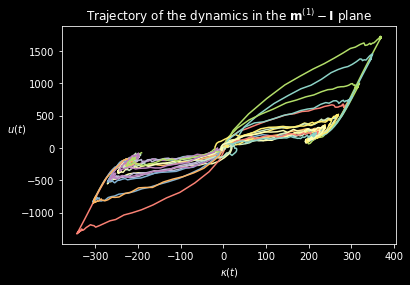

In [24]:
for trial in range(data_size):
    x_projected = m_I_space @ x_t.detach().numpy()[:,trial,:]
    plt.plot(x_projected[0], x_projected[1])
plt.xlabel(r'$\kappa (t)$')
plt.ylabel(r'$u(t)$', rotation = 'horizontal')
plt.title(r'Trajectory of the dynamics in the $\mathbf{m}^{(1)}-\mathbf{I}$ plane')
plt.show()

__Do the dynamics of different trials evolve in an interpretable manner?__

Since the activity of the neurons in a unit rank network is given by a linear combination of $\mathbf{m}^{(1)}$ and $\mathbf{I}$ with the internal collective variables $\mathbf{\kappa}$ and the input $\mathbf{u}(t)$, these trajectories correspond to $\mathbf{\kappa}$ and $\mathbf{u}(t)$ respectively.

__How could you reduce the dimensionality if you did not know $m$ and $I$, as would be the case with an arbitrary RNN, or with experimental data?__

A solution would be to apply PCA by computing the covariance matrix of $\mathbf{x}$ and extract the largest principal components and the corresponding vectors which would then span a new subspace with lower dimensionality.

### Exercise 7

__Using the Gaussian assumption, we are ready for the final step: distilling the trained network into an equivalent one-dimensional dynamical system of the form__
$$\frac{d\kappa}{dt} = -\kappa(t) + \tilde{\sigma}_{mn} \kappa(t) + \tilde{\sigma}_{nI} \nu(t)$$

In [25]:
# Compute the covariances.
m_n = np.array([m_sampled, n_sampled])
sigma_mn = np.cov(m_n)[0,1]

n_I = np.array([n_sampled, I_sampled])
sigma_nI = np.cov(n_I)[0,1]

m_w = np.array([m_sampled, w_sampled])
sigma_mw = np.cov(m_w)[0,1]

I_w = np.array([I_sampled, w_sampled])
sigma_Iw = np.cov(I_w)[0,1]

sigma_m = np.cov(m_sampled)
sigma_I = np.cov(I_sampled)

print(sigma_mn, sigma_nI, sigma_mw, sigma_Iw, sigma_m, sigma_I)

1.7524297316239936 3.391570472374912 0.3016921048916653 -1.272628339665664 2.5349816810021135 23.290451567524254


In [26]:
# Define the equations necessary for the reduced model.
f_kappa = lambda kappa, nu, sigma_tilde_mn, sigma_tilde_nI: -kappa + sigma_tilde_mn*kappa + sigma_tilde_nI*nu
f_kappa_squared = lambda kappa, nu, sigma_tilde_mn, sigma_tilde_nI: (-kappa + sigma_tilde_mn*kappa + sigma_tilde_nI*nu)**2
f_nu = lambda nu, u, tau=0.1: (-nu + u) / tau
tanh_prime = lambda x: 1 / np.cosh(x)**2
f_integral = lambda z, Delta: tanh_prime(Delta * z) * np.exp(-z**2 / 2)

In [27]:
def integrate_system(kappa, nu, u, sigma_m, sigma_I, sigma_mn, sigma_nI, sigma_nw, sigma_Iw, dt):
    Delta = np.sqrt(sigma_m**2 * kappa**2 + sigma_I**2 * u**2)
    neuronal_gain = 1 / 2*np.pi *  integrate.quad(f_integral, a=-np.inf, b=np.inf, args=Delta)[0]
    # neuronal_gain = 1 / 2*np.pi *  integrate.quadrature(f_integral, a=-1e6, b=1e6, args=Delta)[0]
    sigma_tilde_mn = sigma_mn * neuronal_gain
    sigma_tilde_nI = sigma_nI * neuronal_gain
    sigma_tilde_mw = sigma_mw * neuronal_gain
    sigma_tilde_Iw = sigma_Iw * neuronal_gain
    nu = nu + f_nu(nu, u) * dt
    z = sigma_tilde_mw * kappa + sigma_tilde_Iw * nu
    kappa = kappa + f_kappa(kappa, nu, sigma_tilde_mn, sigma_tilde_nI) * dt
    return kappa, nu, z, minimize(f_kappa_squared, 0, args=(nu, sigma_tilde_mn, sigma_tilde_nI))

In [28]:
# Simulate the system over trial and time steps.
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

dt = 0.02
kappa = np.zeros((data_size, t_steps))
nu = np.zeros((data_size, t_steps))
z = np.zeros((data_size, t_steps))
for trial in range(data_size):
    for t in range(t_steps-1):
        kappa[trial,t+1], nu[trial,t+1], z[trial,t+1], res = integrate_system(kappa[trial,t], nu[trial,t], 
                                U[trial,t].detach().numpy(), sigma_m, sigma_I, sigma_mn, sigma_nI, sigma_mw, sigma_Iw, dt)

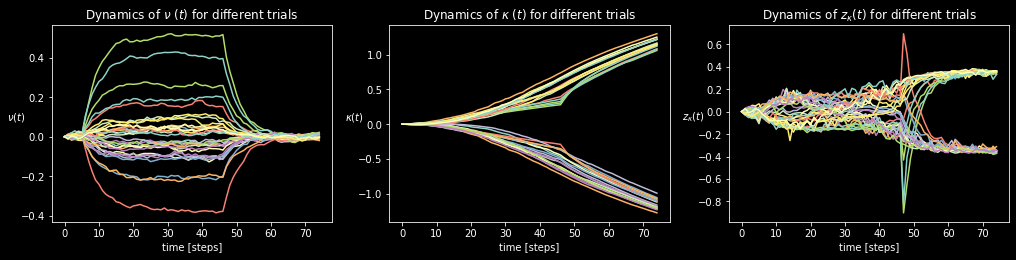

In [29]:
fig, axs = plt.subplots(1, 3, figsize = (14, 3.5), constrained_layout = True)
axs[0].plot(nu.T)
axs[0].set_ylabel(r'$\nu (t)$', rotation = 'horizontal')
axs[0].set_title(r'Dynamics of $\nu \; (t)$ for different trials')
axs[1].plot(kappa.T)
axs[1].set_ylabel(r'$\kappa (t)$', rotation = 'horizontal')
axs[1].set_title(r'Dynamics of $\kappa \; (t)$ for different trials')
axs[2].plot(z.T)
axs[2].set_ylabel(r'$z_{\kappa}(t)$', rotation = 'horizontal')
axs[2].set_title(r'Dynamics of $z_{\kappa}(t)$ for different trials')
for i in range(3):
    axs[i].set_xlabel('time [steps]')
plt.show()

In [30]:
acc_score = accuracy_score(y.detach().numpy(), np.sign(z[:,-1]))
print(f'{acc_score*100}% of the input was classified correctly by the reduced model.')

100.0% of the input was classified correctly by the reduced model.


The equivalent circuit seems to perform the task in the sense that it seems to be successful in reporting whether the fluctuating input $\nu(t)$ was positive or negative. This can be well observed by looking at the third plot showing the values of the readouts that are expressed in terms of the internal and external collective variables $\nu(t)$ and $\kappa(t)$. As such, we can conclude that the task is in fact successfully performed by the reduced model. 

Also, the accuracy score is the same as the score of the trained network.

### Exercise 8

__A complementary way of reverse-engineering a trained RNN, is to analyze its locally linear dynamics around fixed points. This is a standard approach in low-dimensional systems, done numerically when applied to RNNs. Find the fixed points of the low-dimensional circuit by minimizing $(\frac{d\kappa}{dt})^2$ over $\kappa$. You can use scipy’s `minimize` for this.__

In [31]:
res

      fun: 2.65408325658587e-17
 hess_inv: array([[1.04573741]])
      jac: array([1.0706348e-13])
  message: 'Optimization terminated successfully.'
     nfev: 6
      nit: 2
     njev: 3
   status: 0
  success: True
        x: array([0.01443883])

TBD/Optional: We could try to replicate the bifurcation analysis in S1.c of the paper by choosing $\sigma_{nm}$ in the interval $[0, 5]$ and compare the resulting fixed points.

__How would the result change in a circuit that integrates the exact value of its input, rather than the sign?__

TBD

## Parametric working memory

### Exercise 1

__Create a function for generating the data. Both the input $u$ and the target output $y$ are again one-dimensional.__

In [32]:
def get_input_PM(u_1, u_2, t_step):
    '''
    Function to generate the data with fixed delay.
    '''
    u = np.zeros(t_step)
    for t in range(t_step):
        if 5 <= t <= 10:
            u[t] = u_1
        elif 60 <= t <= 70:
            u[t] = u_2
        else:
            u[t] = 0
    
    return u

def generate_data_PM(f_min, f_max, trial_size, t_step, curriculum=False, delay_step=1):
    U = np.zeros((trial_size, t_step))
    y = np.zeros(trial_size)
    
    for trial in range(trial_size):
        f_1 = random.randrange(10, 34, 4)
        f_2 = random.randrange(10, 34, 4)
        
        u_1 = u_i_PM(f_1, f_min, f_max)
        u_2 = u_i_PM(f_2, f_min, f_max)
        
        if curriculum:
            U[trial] = get_input_delayed_PM(u_1, u_2, t_step, delay_step)
        else:
            U[trial] = get_input_PM(u_1, u_2, t_step)
        y[trial] = output_PM(f_1, f_2, f_min, f_max)
    
    return torch.from_numpy(U), torch.from_numpy(y)

In [33]:
u_i_PM = lambda f_i, f_min, f_max: 1 / (f_max - f_min) * (f_i - (f_max + f_min) / 2)
output_PM = lambda f_1, f_2, f_min, f_max: (f_1 - f_2) / (f_max - f_min)

# Generate the data.
f_min = 10
f_max = 34

n_batches = 1
trial_size = batch_size * n_batches
t_step = 75
U_PM, y_PM = generate_data_PM(f_min, f_max, trial_size, t_step)

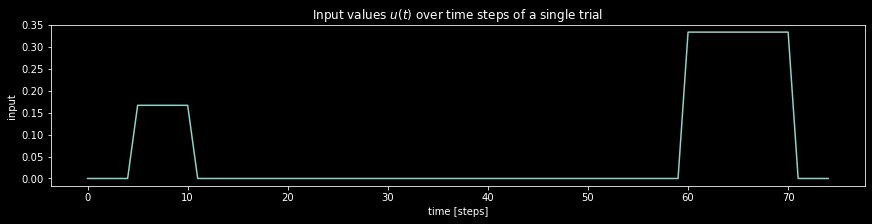

In [34]:
fig = plt.subplots(1, 1, figsize = (12, 3), constrained_layout = True)

for trial in range(trial_size):
    # Plot a trial with f_1 < f_2 to match the plot in the paper.
    if U_PM[trial][5] < U_PM[trial][60] and U_PM[trial][5] > 0:
        plt.plot(U_PM[trial])
        plt.title(r'Input values $u(t)$ over time steps of a single trial')
        plt.xlabel('time [steps]')
        plt.ylabel('input')
        break
plt.show()

### Exercise 2

__Extend your network implementation to allow for recurrent connectivity of arbitrary rank.__

### Exercise 3

__Train a network of size $N = 128$ and rank $R = 2$ by minimizing the mean squared error between the target and the network output during the last 5 time steps of each trial. The loss should drop below 5e-3.__

In [35]:
# Define the model with the same hyperparameters as above except for rank 2.
rank = 2

model_PM = Model(input_size, hidden_size, rank)
model_PM

Model(
  (rnn): RNNLayer(
    (m_list): ParameterList(
        (0): Parameter containing: [torch.FloatTensor of size 128x1]
        (1): Parameter containing: [torch.FloatTensor of size 128x1]
    )
    (n_list): ParameterList(
        (0): Parameter containing: [torch.FloatTensor of size 128x1]
        (1): Parameter containing: [torch.FloatTensor of size 128x1]
    )
  )
)

In [36]:
loss_PM, _, _ = train_network(model_PM, U_PM, y_PM, input_size, hidden_size, t_steps, n_epochs=200, n_last_steps=5)

Epoch: 10/200............. Loss: 0.1466
Epoch: 20/200............. Loss: 0.1127
Epoch: 30/200............. Loss: 0.1124
Epoch: 40/200............. Loss: 0.1122
Epoch: 50/200............. Loss: 0.1121
Epoch: 60/200............. Loss: 0.1120
Epoch: 70/200............. Loss: 0.1120
Epoch: 80/200............. Loss: 0.1119
Epoch: 90/200............. Loss: 0.1118
Epoch: 100/200............. Loss: 0.1117
Epoch: 110/200............. Loss: 0.1116
Epoch: 120/200............. Loss: 0.1115
Epoch: 130/200............. Loss: 0.1115
Epoch: 140/200............. Loss: 0.1114
Epoch: 150/200............. Loss: 0.1113
Epoch: 160/200............. Loss: 0.1113
Epoch: 170/200............. Loss: 0.1112
Epoch: 180/200............. Loss: 0.1112
Epoch: 190/200............. Loss: 0.1111
Epoch: 200/200............. Loss: 0.1111


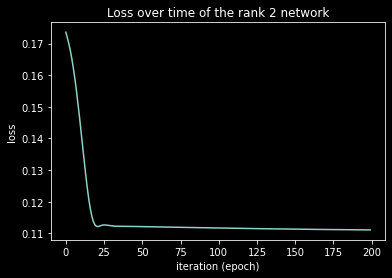

In [37]:
plt.plot(loss_PM)
plt.title('Loss over time of the rank 2 network')
plt.xlabel('iteration (epoch)')
plt.ylabel('loss')
plt.show()

__Try the curriculum approach by gradually increasing the delay, starting from 25 time steps, to see if the network's performance will improve.__

In [38]:
def get_input_delayed_PM(u_1, u_2, t_step, delay_step, delay_period=25):
    u = np.zeros(t_step)
    for t in range(t_step):
        if 5 <= t <= 10:
            u[t] = u_1
        elif (delay_step + 10+delay_period) <= t <= (delay_step + delay_period+20):
            u[t] = u_2
        else:
            u[t] = 0
    
    return u

In [50]:
'''
Create a new data set to train the network using curriculum learning starting from 25 time steps. The delay will increase 
by 5 steps after each minibatch. Therefore, 5 minibatches (each of size 32) are created to eventually arrive at a delay of 
50 time steps which corresponds to the "original" delay.
'''
n_batches_curr = 6
trial_size = batch_size
U_PM_curr = torch.zeros(n_batches_curr, batch_size, t_step)
y_PM_curr = torch.zeros(n_batches_curr, batch_size)

for delay_step in range(6):
    U_PM_curr[delay_step], y_PM_curr[delay_step] = generate_data_PM(f_min, f_max, trial_size, t_step, curriculum=True, 
                                                                    delay_step=5*delay_step)

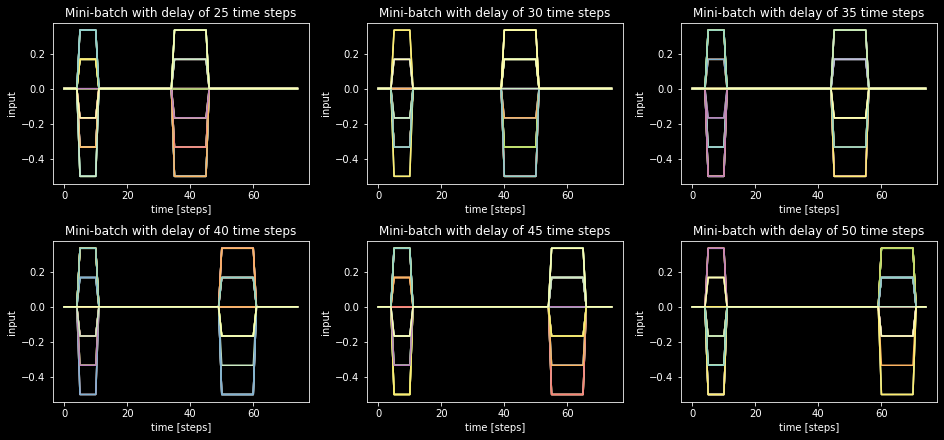

In [51]:
fig, axs = plt.subplots(2, 3, figsize = (13, n_batches_curr), constrained_layout = True)

for i, ax in enumerate(axs.flatten()):
    plt.sca(ax)
    plt.plot(U_PM_curr[i].T)
    plt.title(f'Mini-batch with delay of {(i*5)+25} time steps')
    plt.xlabel('time [steps]')
    plt.ylabel('input')

In [65]:
# We need to create a new model, otherwise the parameters of the already trained model are used.
model_PM_curr = Model(input_size, hidden_size, rank)
model_PM_curr

Model(
  (rnn): RNNLayer(
    (m_list): ParameterList(
        (0): Parameter containing: [torch.FloatTensor of size 128x1]
        (1): Parameter containing: [torch.FloatTensor of size 128x1]
    )
    (n_list): ParameterList(
        (0): Parameter containing: [torch.FloatTensor of size 128x1]
        (1): Parameter containing: [torch.FloatTensor of size 128x1]
    )
  )
)

In [66]:
# Reshape input and output matrices.
U_PM_curr_resh = U_PM_curr.reshape(-1, 75)  # (p x t_step) matrix
y_PM_curr_resh = y_PM_curr.reshape(-1)      # vector of size p, p = 6*32 = 192

loss_PM_curr, _, _ = train_network(model_PM_curr, U_PM_curr_resh, y_PM_curr_resh, input_size, hidden_size, t_steps, n_epochs=300)

Epoch: 10/300............. Loss: 0.0967
Epoch: 20/300............. Loss: 0.0965
Epoch: 30/300............. Loss: 0.0960
Epoch: 40/300............. Loss: 0.0942
Epoch: 50/300............. Loss: 0.0455
Epoch: 60/300............. Loss: 0.0213
Epoch: 70/300............. Loss: 0.0228
Epoch: 80/300............. Loss: 0.0275
Epoch: 90/300............. Loss: 0.0277
Epoch: 100/300............. Loss: 0.0261
Epoch: 110/300............. Loss: 0.0248
Epoch: 120/300............. Loss: 0.0211
Epoch: 130/300............. Loss: 0.0165
Epoch: 140/300............. Loss: 0.0160
Epoch: 150/300............. Loss: 0.0157
Epoch: 160/300............. Loss: 0.0176
Epoch: 170/300............. Loss: 0.0173
Epoch: 180/300............. Loss: 0.0194
Epoch: 190/300............. Loss: 0.0197
Epoch: 200/300............. Loss: 0.0141
Epoch: 210/300............. Loss: 0.0468
Epoch: 220/300............. Loss: 0.0162
Epoch: 230/300............. Loss: 0.0164
Epoch: 240/300............. Loss: 0.0196
Epoch: 250/300...........

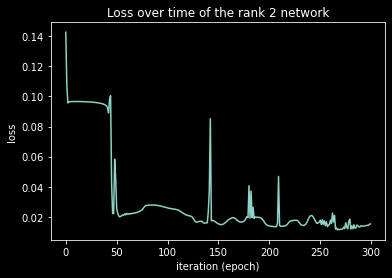

In [67]:
plt.plot(loss_PM_curr)
plt.title('Loss over time of the rank 2 network')
plt.xlabel('iteration (epoch)')
plt.ylabel('loss')
plt.show()

Fluctuating a litte bit though (on a very low level) but the losses are generally lower compared to the previous network.

### Exercise 4

__Visualize the connectivity patterns from the trained network, and compare with those reported by Dubreuil et al. (their figure 3b).__

_First, look at the patterns of the network trained WITHOUT curriculum learning!_

In [44]:
def extract_PM_statistics(model):
    # Statistics of the pattern loadings for a rank 2 network after training.
    m1 = model.rnn.m_list[0].detach().numpy().reshape(hidden_size)
    m2 = model.rnn.m_list[1].detach().numpy().reshape(hidden_size)
    n1 = model.rnn.n_list[0].detach().numpy().reshape(hidden_size)
    n2 = model.rnn.n_list[1].detach().numpy().reshape(hidden_size)
    I = model.I.detach().numpy().reshape(hidden_size)
    w = model.w.detach().numpy().reshape(hidden_size)
    
    return m1, m2, n1, n2, I, w

In [45]:
def plt_PM_patterns(m1, m2, n1, n2, figtitle):
    fig, axs = plt.subplots(1, 2, figsize = (10, 4), constrained_layout = True)
    fig.suptitle(figtitle, fontsize=14)

    axs[0].set_title(r'$\mathbf{m^{(1)}}$-$\mathbf{n^{(1)}}$ projection')
    axs[0].scatter(m1, n1)
    axs[0].set_xlabel(r'$m^{(1)}$')
    axs[0].set_ylabel(r'$n^{(1)}$', rotation = 'horizontal')
    
    axs[1].set_title(r'$\mathbf{m^{(2)}}$-$\mathbf{n^{(2)}}$ projection')
    axs[1].scatter(m2, n2)
    axs[1].set_xlabel(r'$m^{(2)}$')
    axs[1].set_ylabel(r'$n^{(2)}$', rotation = 'horizontal')
    plt.show()

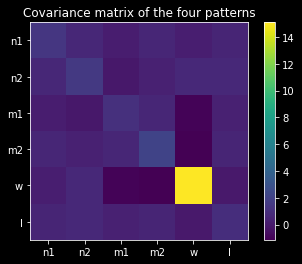

In [68]:
m1, m2, n1, n2, I, w = extract_PM_statistics(model_PM)

labels = ['n1', 'n2', 'm1', 'm2', 'w', 'I']
cov = np.cov(np.array([n1, n2, m1, m2, w, I]))
plt_cov(cov, 'Covariance matrix of the four patterns', labels)

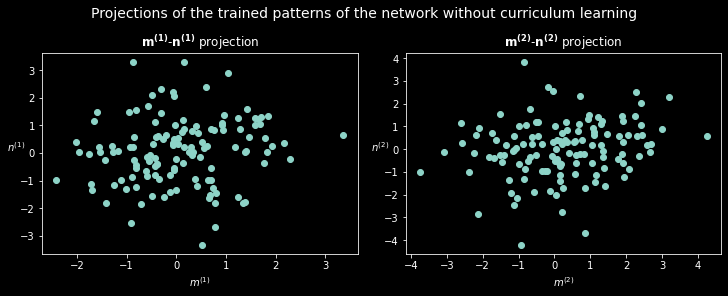

In [69]:
plt_PM_patterns(m1, m2, n1, n2, figtitle='Projections of the trained patterns of the network without curriculum learning')

_Now, look at the patterns of the network trained WITH curriculum learning!_

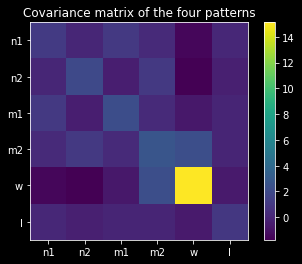

In [70]:
m1_curr, m2_curr, n1_curr, n2_curr, I_curr, w_curr = extract_PM_statistics(model_PM_curr)

cov = np.cov(np.array([n1_curr, n2_curr, m1_curr, m2_curr, w_curr, I_curr]))
plt_cov(cov, 'Covariance matrix of the four patterns', labels)

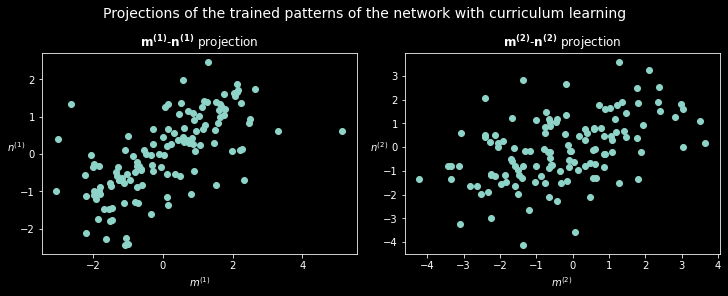

In [71]:
plt_PM_patterns(m1_curr, m2_curr, n1_curr, n2_curr, figtitle='Projections of the trained patterns of the network with curriculum learning')

We see that the data points in the $m^{(1)}-n^{(1)}$ projection are closer to each other compared to the data points in the $m^{(2)}-n^{(2)}$ projection which we also see in the plots of the paper.

__Why do these patterns work? Why could a rank 1 network not solve this task?__

TBD (see my annotations next to Table 1)

### Exercise 5

__Project the $N$-dimensional activity onto the $m_1,m_2$, to obtain the latent variables $\kappa_1, \kappa_2$.__

In [73]:
# Maybe we should do ex 6 first and then ex 5?